# Reinforcement learning

## An interactive notebook training Keras to play Catch

This is an interactive version of [Eder Santana's](http://edersantana.github.io/) [Keras plays catch, a single file Reinforcement Learning example](https://edersantana.github.io/articles/keras_rl/). The first interactive version of the original code was written by [cadurosar](https://gist.github.com/cadurosar/bd54c723c1d6335a43c8). I added comments and explanations, following the explanation laid out in [Demystifying Deep Reinforcement Learning](http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/) by [Tambet Matiisen](https://github.com/tambetm/). Please visit all the aforementioned authors websites for more information and give them credit for doing all the heavy lifting. This code is realeased under an MIT license, but please be aware that Google has the patent for Q-Learning.


## The task

Catch is a very simple arcade game, which you might have played as a child. Fruits are falling from the top of the screen and the player has to catch them with a basket. For every fruit caught, the player gets a point. For every fruit lost, the player looses a point. Our goal here is to let the computer play Catch by itself.

When playing Catch, the player has to decide between 3 possible actions. The player can move the basket to the left, to the right, or stay put. The basis for this decision is the current state of the game, the position of the fruit and the position of the basket, which are both visible on the screen. Our goal is therefore to create a model, which, given the content of the game screen, chooses the action which leads to the highest score possible.

This task could be framed as a simple classification problem. We could collect training data by letting expert human players play lots of games and then train a model on choosing the 'correct' action that mirrors the expert players. This is not how humans learn however. Humans can learn a game like catch by themselves, without guidiance. This is very useful. Imagine you would have to hire a bunch of experts to perform a task thousands of times everytime you wanted to learn something as simple as Catch. It would be very expensive and very slow. Here, we are going to demonstrate a technique called reinforcement learning, where the model learns from experience, rather than labeled training data.

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np
import time
import imageio
from IPython import display
import seaborn
seaborn.set()

/Users/marco/anaconda3/envs/trackmlK/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/marco/anaconda3/envs/trackmlK/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as utils_data
import torch.nn.functional as F

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('pytorch version: ' + torch.__version__ + '\ndevice: ' + str(device))

pytorch version: 0.4.0
device: cpu


# Setting up the game

This is the code for the actual game we are training on.
Catch is a simple game you might have played as a child. In the game, fruits, represented by white tiles, fall from the top. The goal is to catch the fruits with a basked (represented by white tiles, this is deep learning, not game design). If you catch a fruit, you get a point (your score goes up by one), if you miss a fruit, you loose one (your score goes down).

Don't worry all too much about the details of the implementation, the focus here should be on the AI, not on the game.
Just make sure you run this cell so that it is defined.

In [11]:
class Catch(object):
    """
    Class catch is the actual game.
    In the game, fruits, represented by white tiles, fall from the top.
    The goal is to catch the fruits with a basked (represented by white tiles, this is deep learning, not game design).
    """
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas
        
    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]

In addition to defining the game we need to define some helper variables and functions.
Run the cells below to define them, then we will get to the meat and the potatoes of this notebook.

In [12]:
"""
Here we define some variables used for the game and rendering later
"""
#last frame time keeps track of which frame we are at
last_frame_time = 0
#translate the actions to human readable words
translate_action = ["Left","Stay","Right","Create Ball","End Test"]
#size of the game field
grid_size = 10

In [13]:
def display_screen(action,points,input_t):
    #Function used to render the game screen
    #Get the last rendered frame
    global last_frame_time
    print("Action %s, Points: %d" % (translate_action[action],points))
    #Only display the game screen if the game is not over
    if("End" not in translate_action[action]):
        #Render the game with matplotlib
        plt.imshow(input_t.reshape((grid_size,)*2),
               interpolation='none', cmap='gray')
        #Clear whatever we rendered before
        display.clear_output(wait=True)
        #And display the rendering
        display.display(plt.gcf())
    #Update the last frame time
    last_frame_time = set_max_fps(last_frame_time)
    
    
def set_max_fps(last_frame_time,FPS = 1):
    current_milli_time = lambda: int(round(time.time() * 1000))
    sleep_time = 1./FPS - (current_milli_time() - last_frame_time)
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time()

# Deep reinforcement learning

After the game is all setup, let's get to the exciting part.

For a deeper understanding of what is going on in the next couple of cells, definetly check out [Demystifying Deep Reinforcement Learning](http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/) and the links posted at the end of Tambet's post.

## Q-learning intuition.

A good way to understand Q-learning is to compare playing Catch with playing chess. In both games you are given a state s (chess: positions of the figures on the board, Catch: location of the fruit and the basket), on which you have to take an action a (chess: move a figure, Catch: move the basket to the left, right, or stay where you are). As a result there will be some reward r and a new state s’. The problem with both Catch and and chess is that the rewards will not appear immediately after you have taken the action. In Catch, you only earn rewards when the fruits hit the basket or fall on the floor, and in chess you only earn a reward when you win or loose the game. Rewards are _sparsely distributed_, most of the time, r will be 0. When there is a reward, it is not always a result of the action taken immediately before. Some action taken long before might have cause the victory. Figuring out which action is responsible for the reward is often referred to as the _credit assignment problem_.

Because rewards are delayed, good chess players do not choose their plays only by the immediate reward, but by the _expected future reward_. They do not only think about whether they can eliminate an opponents figure in the next move, but how taking a certain action now will help them in the long run. 
In Q-learning, we choose our action based on the highest expected future reward. While in state s, we estimate the future reward for each possible action a. We assume that after we have taken action a and moved to the next state s’, everything works out perfectly. Like in finance, we discount future rewards, since they are uncertain.
The expected future reward Q(s,a) given a state s and an action a is therefore the reward r that directly follows from a plus the expected future reward Q(s’,a’) if the optimal action a’ is taken in the following state s’, discounted by the discount factor gamma.

Q(s,a) = r + gamma * max Q(s’,a’)

Good chess players are very good at estimating future rewards in their head. In other words, their function Q(s,a) is very precise. Most chess practice revolves around developing a better Q function. Players peruse many old games to learn how specific moves played out in the past, and how likely a given action is to lead to victory.

But how could we estimate a good function Q? This is where neural networks come into play.

## Regression after all

When playing, we generate lots of experiences consisting of the initial state s, the action taken a, the reward earned r and the state that followed s’. These experiences are our training data. We can frame the problem of estimating Q(s,a) as a simple regression problem. Given an input vector consisting of s and a the neural net is supposed to predict the a value of Q(s,a) equal to the target: r + gamma * max Q(s’,a’). If we are good at predicting Q(s,a) for different states s and actions a, we have a good approximation of Q. Note that Q(s’,a’) is _also_ a prediction of the neural network we are training. 

Given a batch of experiences < s, a, r, s’ >, the training process then looks as follows:
1. For each possible action a’ (left, right, stay), predict the expected future reward Q(s’,a’) using the neural net
2. Choose the highest value of the three predictions max Q(s’,a’)
3. Calculate r + gamma * max Q(s’,a’). This is the target value for the neural net
4. Train the neural net using the loss function 1/2(predicted_Q(s,a) - target)^2

During gameplay, all the experiences are stored in a replay memory. This is the class below. 

The remember function simply saves an experience to a list.
The get_batch function performs steps 1 to 3 of the list above and returns an input and a target vector. The actual training is done in a function discussed below.

In [81]:
class ExperienceReplay(object):
    """
    During gameplay all the experiences < s, a, r, s’ > are stored in a replay memory. 
    In training, batches of randomly drawn experiences are used to generate the input and target for training.
    """
    def __init__(self, max_memory=100, discount=.9):
        """
        Setup
        max_memory: the maximum number of experiences we want to store
        memory: a list of experiences
        discount: the discount factor for future experience
        
        In the memory the information whether the game ended at the state is stored seperately in a nested array
        [...
        [experience, game_over]
        [experience, game_over]
        ...]
        """
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        #Save a state to memory
        self.memory.append([states, game_over])
        #We don't want to store infinite memories, so if we have too many, we just delete the oldest one
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        
        #How many experiences do we have?
        len_memory = len(self.memory)
        
        #Calculate the number of actions that can possibly be taken in the game
        num_actions = model.num_actions
        
        #Dimensions of the game field
        env_dim = self.memory[0][0][0].shape[1]
        
        #We want to return an input and target vector with inputs from an observed state...
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        
        #...and the target r + gamma * max Q(s’,a’)
        #Note that our target is a matrix, with possible fields not only for the action taken but also
        #for the other possible actions. The actions not take the same value as the prediction to not affect them
        targets = np.zeros((inputs.shape[0], num_actions))
        
        #We draw states to learn from randomly
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            """
            Here we load one transition <s, a, r, s’> from memory
            state_t: initial state s
            action_t: action taken a
            reward_t: reward earned r
            state_tp1: the state that followed s’
            """
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            
            #We also need to know whether the game ended at this state
            game_over = self.memory[idx][1]

            #add the state s to the input
            inputs[i:i+1] = state_t
            
            # First we fill the target values with the predictions of the model.
            # They will not be affected by training (since the training loss for them is 0)
            targets[i] = model(torch.from_numpy(state_t).double().to(device)).detach().numpy()[0]
            
            """
            If the game ended, the expected reward Q(s,a) should be the final reward r.
            Otherwise the target value is r + gamma * max Q(s’,a’)
            """
            #  Here Q_sa is max_a'Q(s', a')
            Q_sa = np.max(model(torch.from_numpy(state_tp1).double().to(device)).detach().numpy()[0])
            
            #if the game ended, the reward is the final reward
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # r + gamma * max Q(s’,a’)
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets


## Defining the model

Now it is time to define model that will learn Q. We are using Keras as a frontend to either Tensorflow or Theano. Our baseline model is a very simple 3 layer dense network. You can play around with more complex models and see whether you can improve performance.

In [82]:
class Baseline_Model(nn.Module):
    def __init__(self, grid_size,num_actions,hidden_size):
        super(Baseline_Model, self).__init__()

        self.grid_size = grid_size
        self.num_actions = num_actions
        self.hidden_size = hidden_size
        
        self.linear1 = nn.Linear(self.grid_size ** 2 , self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.linear3 = nn.Linear(self.hidden_size, self.num_actions)
        
    def forward(self, grid):
        
        act = self.linear1(grid)
        act = F.relu(act)        
        act = self.linear2(act)
        act = F.relu(act)
        act = self.linear3(act)
        
        return act

## Parameters

Before we start training, we need to define some parameters. You can experiment with these, too.

In [83]:
# parameters
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 1 # Number of experiences we use for training per batch
grid_size = 10 # Size of the playing field

In [84]:
model = Baseline_Model(grid_size,num_actions,hidden_size).double().to(device)
loss_f = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print('Total number of paramters: %d' % total_params)

Baseline_Model(
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=3, bias=True)
)
Total number of paramters: 20503


In [85]:
# Define environment/game
env = Catch(grid_size)

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

## Training the model

Training is relatively straightforward. We let the model play the game. While it plays, it generates training data in form of experiences. We use this training data to train our Q estimator.

In [90]:
def train(model,epochs, verbose = 1):
    # Train
    #Reseting the win counter
    win_cnt = 0
    # We want to keep track of the progress of the AI over time, so we save its win count history
    win_hist = []
    #Epochs is the number of games we play
    for e in range(epochs):
        loss = 0.
        #Resetting the game
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()
        
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            
            """
            We want to avoid that the learner settles on a local minimum.
            Imagine you are eating eating in an exotic restaurant. After some experimentation you find 
            that Penang Curry with fried Tempeh tastes well. From this day on, you are settled, and the only Asian 
            food you are eating is Penang Curry. How can your friends convince you that there is better Asian food?
            It's simple: Sometimes, they just don't let you choose but order something random from the menu.
            Maybe you'll like it.
            The chance that your friends order for you is epsilon
            """
            if np.random.rand() <= epsilon:
                #Eat something random from the menu
                action = np.random.randint(0, num_actions, size=1)
            else:
                #Choose yourself
                #q contains the expected rewards for the actions
                q = model(torch.from_numpy(input_tm1).double().to(device))
                #We pick the action with the highest expected reward
                action = np.argmax(q[0].detach().numpy())

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            #If we managed to catch the fruit we add 1 to our win counter
            if reward == 1:
                win_cnt += 1        
            
            #Uncomment this to render the game here
            #display_screen(action,3000,inputs[0])
            
            """
            The experiences < s, a, r, s’ > we make during gameplay are our training data.
            Here we first save the last experience, and then load a batch of experiences to train our model
            """
            
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)    
            
            # Load batch of experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
  
            # train model on experiences
            optimizer.zero_grad()
            output_model = model(torch.from_numpy(inputs).double().to(device))
            batch_loss = loss_f(output_model, torch.from_numpy(targets).double().to(device))

            batch_loss.backward()
            optimizer.step()
            
            #print(loss)
            loss += batch_loss.item()
        if verbose > 0:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
        win_hist.append(win_cnt)
    return win_hist

## Playing many games

To become a good player, our model needs to play _many_ games. I found that after about 4,000 games it becomes a decent player. For sake of a readable notebook I have disabled the output of the trainer here. See the section on evaluating progress below for a chart.

In [91]:
epoch = 5000 # Number of games played in training, I found the model needs about 4,000 games till it plays well
# Train the model
# For simplicity of the noteb
hist = train(model,epoch,verbose=0)
print("Training done")

Training done


## Testing the model

Now that we have a great Catch player at hand, we want to see it in action! The test function is very similar to the train function. Only that in testing we do not save the experiences and train on them. But we now get to use the rendering functions defined above to watch our model play!

In [92]:
def test(model):
    #This function lets a pretrained model play the game to evaluate how well it is doing
    global last_frame_time
    plt.ion()
    # Define environment, game
    env = Catch(grid_size)
    #c is a simple counter variable keeping track of how much we train
    c = 0
    #Reset the last frame time (we are starting from 0)
    last_frame_time = 0
    #Reset score
    points = 0
    #For training we are playing the game 10 times
    for e in range(10):
        loss = 0.
        #Reset the game
        env.reset()
        #The game is not over
        game_over = False
        # get initial input
        input_t = env.observe()
        #display_screen(3,points,input_t)
        c += 1
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            #Feed the learner the current status and get the expected rewards for different actions from it
            q = model(torch.from_numpy(input_tm1).double().to(device)).detach().numpy()
            #Select the action with the highest expected reward
            action = np.argmax(q[0])
            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            #Update our score
            points += reward
            display_screen(action,points,input_t)
            c += 1

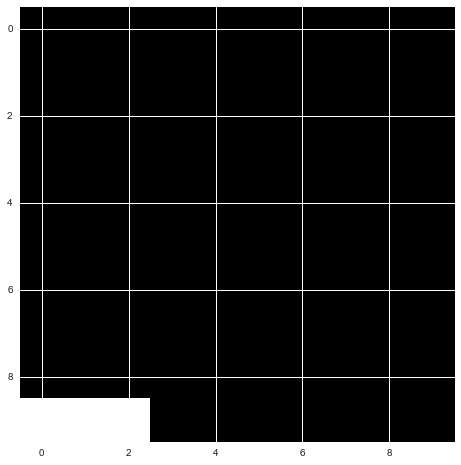

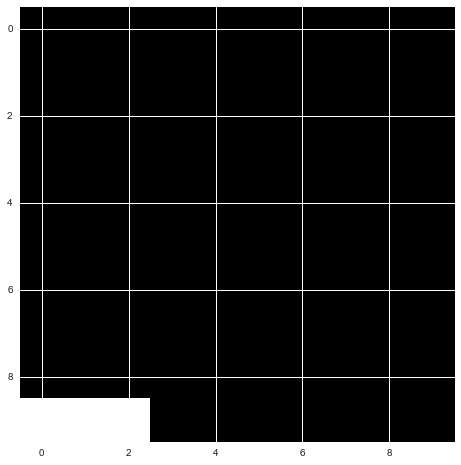

In [106]:
plt.figure(figsize=(12,8))
test(model)

## Evaluating progress

That demo is pretty impressive huh? Before we end this little excursion, let's have a closer look at how our model actually did at learning. Earlier, we saved the history of victories. Now we can plot the moving average of the difference, that is, how many additional victories did the model score per extra game. 1 extra victory per game means the model wins every game (it catches every fruit), 0 means it looses all of them. As you can see the model approaches a 100% victory rate over time. After 4000 plays, the model wins relatively consistently. The random drops in performance are likely due to the random choice epsilon that are made from time to time. A better model would get closer to 100% faster.

Text(0,0.5,'Average of victories per game')

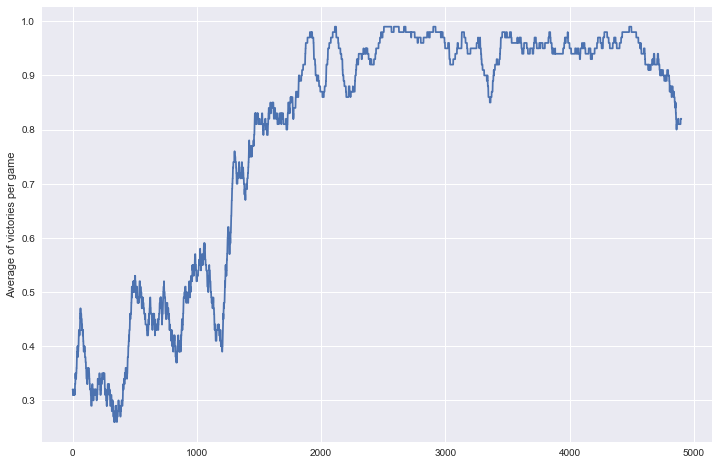

In [107]:
plt.figure(figsize=(12,8))
def moving_average_diff(a, n=100):
    diff = np.diff(a)
    ret = np.cumsum(diff, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average_diff(hist))
plt.ylabel('Average of victories per game')